In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
sns.set_context("notebook")
plt.figure(figsize=(40, 20))


from sklearn.model_selection import KFold,cross_val_score,train_test_split
# from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")



train = pd.read_csv("train.csv")
train = train[train["age"]>22]#これ入れると大幅に良くなる
test  = pd.read_csv("test.csv")

#両データに欠損値が無いことを確認済

# カラム	ヘッダ名称	データ型	説明
# 0	id	int	行の通し番号
# 1	age	int	年齢
# 2	job	varchar	職種
# 3	marital	varchar	未婚/既婚
# 4	education	varchar	教育水準
# 5	default	varchar	債務不履行があるか（yes, no）
# 6	balance	int	年間平均残高（€）
# 7	housing	varchar	住宅ローン（yes, no）
# 8	loan	varchar	個人ローン（yes, no）
# 9	contact	varchar	連絡方法
# 10	day	int	最終接触日
# 11	month	char	最終接触月
# 12	duration	int	最終接触時間（秒）
# 13	campaign	int	現キャンペーンにおける接触回数
# 14	pdays	int	経過日数：前キャンペーン接触後の日数
# 15	previous	int	接触実績：現キャンペーン以前までに顧客に接触した回数
# 16	poutcome	varchar	前回のキャンペーンの成果
# 17	y	boolean	定額預金申し込み有無（1:有り, 0:無し）


In [2]:
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27099.000000,27099.000000,27099.000000,27099.000000,27099.000000,27099.000000,27099.000000,27099.000000,27099.000000
mean,13549.832503,36.073803,47684.829403,16.747076,229.333333,1.775859,432.494446,0.085649,0.077900
std,7823.193338,7.816093,31649.753211,8.569368,204.939565,0.950051,252.147500,0.365711,0.268018
min,0.000000,24.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6775.500000,31.000000,20016.500000,8.000000,121.000000,1.000000,214.500000,0.000000,0.000000
50%,13550.000000,33.000000,47629.000000,17.000000,158.000000,1.000000,432.000000,0.000000,0.000000
75%,20324.500000,37.000000,75332.000000,26.000000,345.000000,2.000000,650.000000,0.000000,0.000000
max,27099.000000,90.000000,102121.000000,31.000000,3076.000000,5.000000,870.000000,3.000000,1.000000


In [3]:
# train["job_tgt_enc"] = train.groupby("job")["y"].transform("mean")
# test["job_tgt_enc"] = test["job"].map(train.groupby("job")["y"].mean())
#これが一番いいあげ
train["mn_tgt_enc"] = train.groupby("month")["y"].transform("mean")
test["mn_tgt_enc"] = test["month"].map(train.groupby("month")["y"].mean())
# train["ed_tgt_enc"] = train.groupby("education")["y"].transform("mean")
# test["ed_tgt_enc"] = test["education"].map(train.groupby("education")["y"].mean())
# train["ct_tgt_enc"] = train.groupby("contact")["y"].transform("mean")
# test["ct_tgt_enc"] = test["contact"].map(train.groupby("contact")["y"].mean())
# train["age_tgt_enc"] = train.groupby("age")["y"].transform("mean")
# test["age_tgt_enc"] = test["age"].map(train.groupby("age")["y"].mean())
# train["cam_tgt_enc"] = train.groupby("campaign")["y"].transform("mean")
# test["cam_tgt_enc"] = test["campaign"].map(train.groupby("campaign")["y"].mean())
train["mn_tgt_dr"] = train.groupby("duration")["y"].transform("mean")
test["mn_tgt_dr"] = test["duration"].map(train.groupby("duration")["y"].mean())
train["mn_tgt_dy"] = train.groupby("day")["y"].transform("mean")
test["mn_tgt_dy"] = test["day"].map(train.groupby("day")["y"].mean())
train["mn_tgt_ag"] = train.groupby("age")["y"].transform("mean")
test["mn_tgt_ag"] = test["age"].map(train.groupby("age")["y"].mean())
train["mn_tgt_p"] = train.groupby("poutcome")["y"].transform("mean")
test["mn_tgt_p"] = test["poutcome"].map(train.groupby("poutcome")["y"].mean())
# train["mn_tgt_pr"] = train.groupby("previous")["y"].transform("mean")
# test["mn_tgt_pr"] = test["previous"].map(train.groupby("previous")["y"].mean())





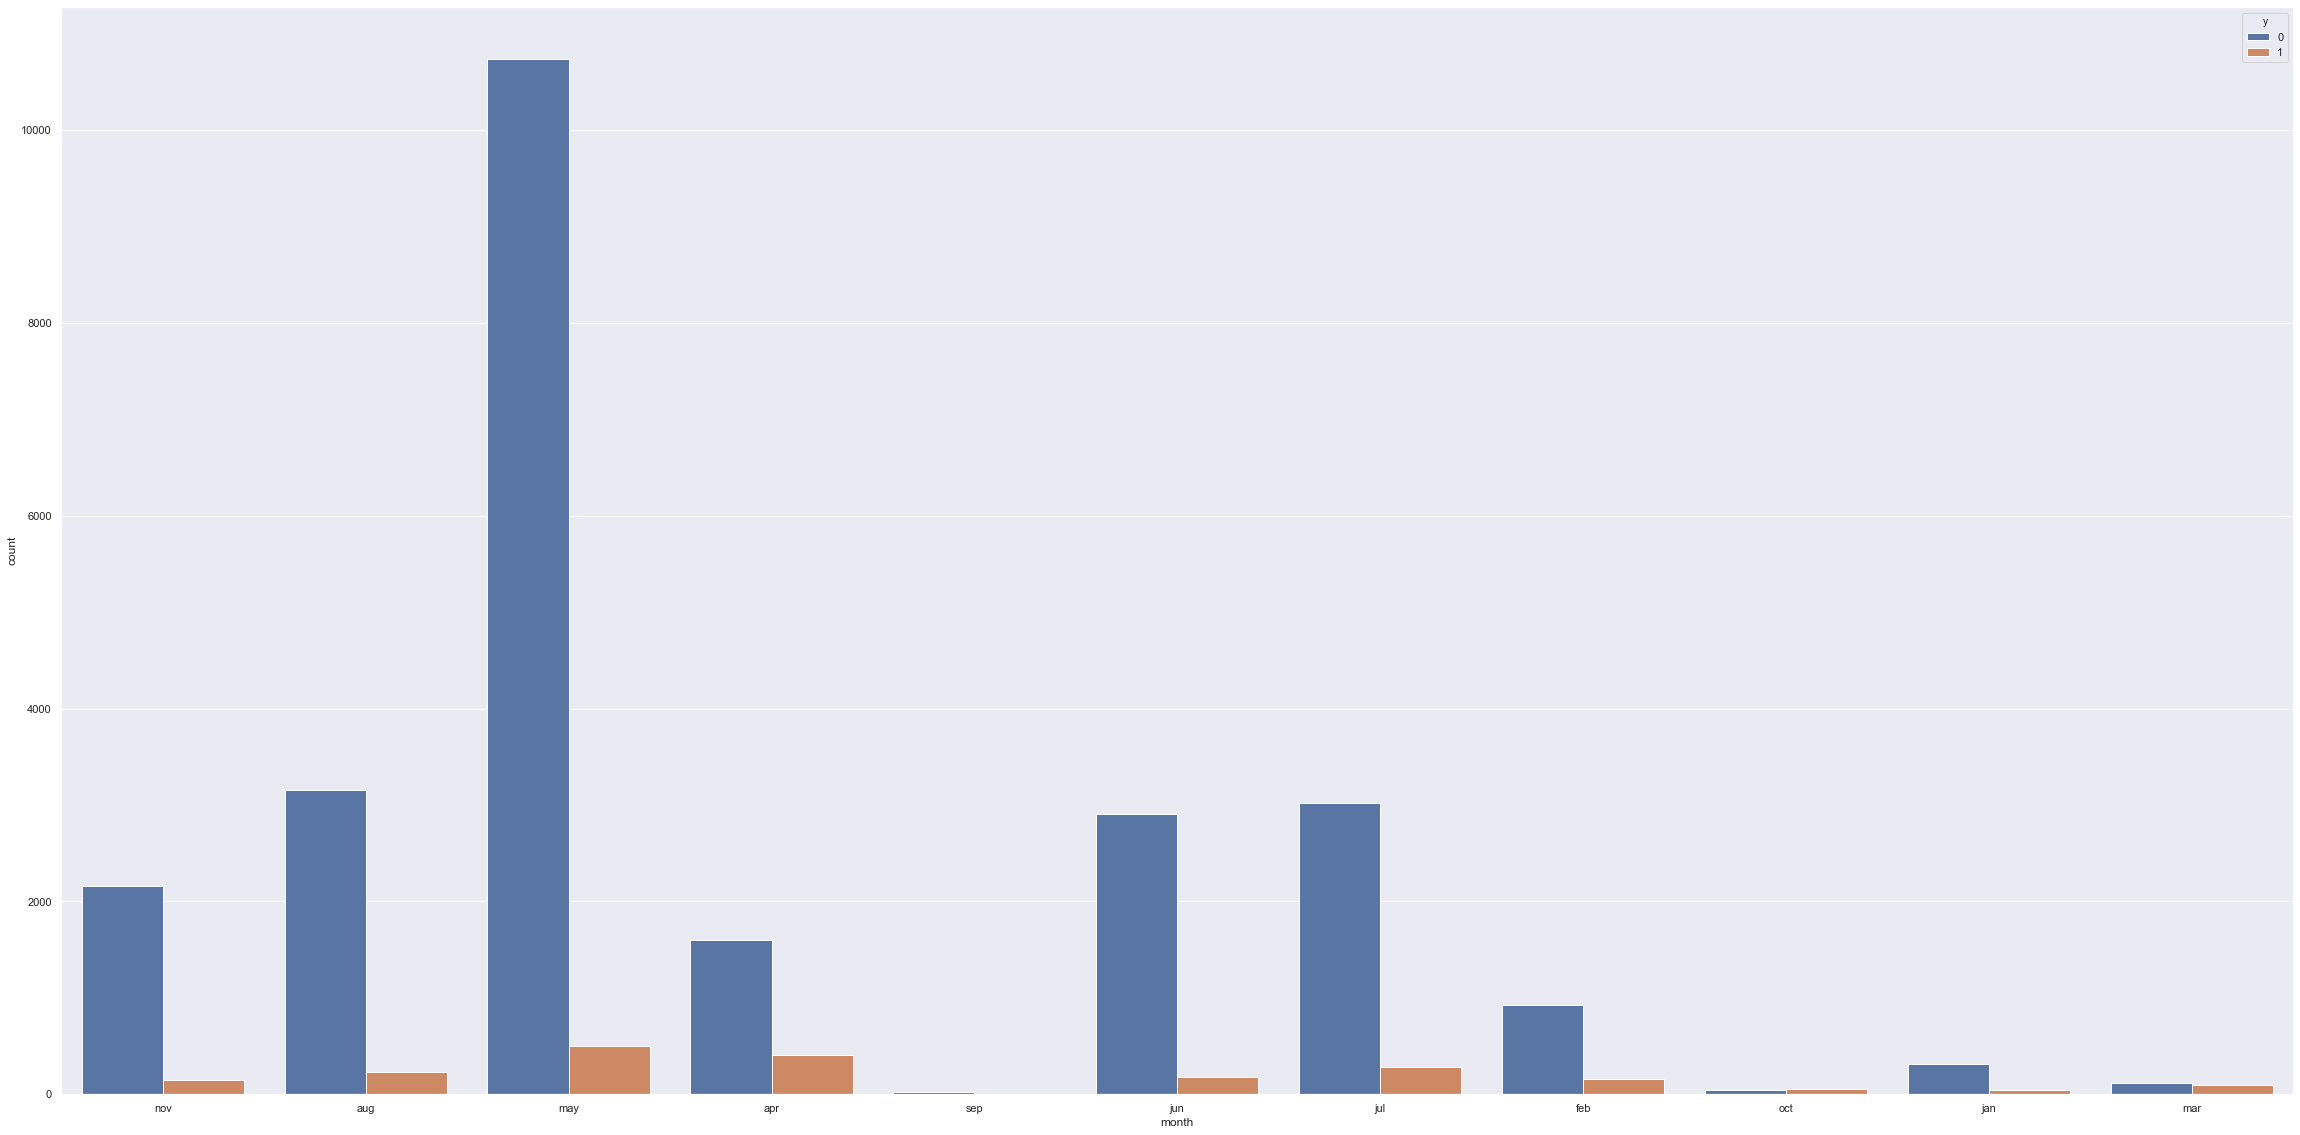

In [4]:

plt.figure(figsize=(40, 20))
sns.countplot(x="month",hue="y",data=train)
# sns.distplot(test["duration"])

In [5]:
# train.tail(50)

In [6]:
train["contact"] = train["contact"].replace("cellular",1).replace("telephone",2).replace("unknown",3)
test["contact"] = test["contact"].replace("cellular",1).replace("telephone",2).replace("unknown",3)
train["education"] = train["education"].replace("unknown",1).replace("tertiary",2).replace("secondary",3).replace("primary",4)
test["education"] = test["education"].replace("unknown",1).replace("tertiary",2).replace("secondary",3).replace("primary",4)
train["marital"] = train["marital"].replace("single",1).replace("married",2).replace("divorced",3)
test["marital"] = test["marital"].replace("single",1).replace("married",2).replace("divorced",3)
train["success"] = train["poutcome"].str.contains("success")
test["success"] = test["poutcome"].str.contains("success")
train["success"] =train["success"].replace(True,1).replace(False,0)
test["success"] =test["success"].replace(True,1).replace(False,0)
train["loan"] =train["loan"].replace("yes",1).replace("no",0)
test["loan"] =test["loan"].replace("yes",1).replace("no",0)
train["housing"] =train["housing"].replace("yes",1).replace("no",0)
test["housing"] =test["housing"].replace("yes",1).replace("no",0)
# train["310"] = train["month"].apply(lambda x:1 if x=="mar" or x=="oct" else 0)
# test["310"] = test["month"].apply(lambda x:1 if  x=="mar" or x=="oct" else 0)
# train["tgt_310"] = train.groupby("310")["y"].transform("mean")
# test["tgt_310"] = test["310"].map(train.groupby("310")["y"].mean())


# train["camp_0"] = train["campaign"].apply(lambda x:1 if x==0 else 0)
# test["camp_0"] = test["campaign"].apply(lambda x:1 if x==0 else 0)
# train["bl"] = train["balance"].apply(lambda x: 1 if x<0 else 0)
# test["bl"] = test["balance"].apply(lambda x: 1 if x<0 else 0)

# train["student"] = train["job"].str.contains("student")
# test["student"] = test["job"].str.contains("student")
# train["wariai"] = train["campaign"]/(train["campaign"]+train["previous"])
# test["wariai"] = test["campaign"]/(test["campaign"]+test["previous"])
# train["age"] = np.log(train["age"])
# test["age"] = np.log(test["age"])



In [7]:
y = train["y"]
del train["y"]

In [8]:
alldata=pd.concat([train,test]).reset_index(drop=True)
# alldata.dtypes
def label_encording(data,ls):
    for column in ls:
        le=preprocessing.LabelEncoder()
        le.fit(data[column])
        data[column]=le.transform(data[column])
        
label_col=["job","default","month","poutcome"]
label_encording(alldata,label_col)

# alldata["meet"] = alldata["campaign"] + alldata["previous"]*2
# alldata["meet2"] = alldata["campaign"] * alldata["previous"]
# alldata["balance*campaign"] = alldata["campaign"]*alldata["balance"]
# alldata["kourei"] = alldata["age"].apply(lambda x: 1 if x>60 or x<20 else 0)
# alldata["pd"] = alldata["pdays"].apply(lambda x: 1 if x>0 else 0)

# alldata["dur_1min"] = alldata["duration"].apply(lambda x: 1 if x>=300 else 0)
# alldata["dur_hou"] = alldata["duration"].apply(lambda x:round(x/1000))
# alldata["kake"] = alldata["housing"]*alldata["loan"]

del alldata["default"]#delしないとLB悪化する
del alldata["education"]

del alldata["balance"]#delしない方がCVやや悪化
del alldata["pdays"]#delしない方がCVやや悪化
# del alldata["duration"]#delしたらCV悪化
# del alldata["campaign"] #delの方がいいのか？
# del alldata["housing"]#delしたらCV悪化
# del alldata["age"]
# del alldata["marital"]#delしたらCV悪化

# del alldata["loan"]#delしたらCV悪化
del alldata["id"]
# del alldata["poutcome"]#delしたらCV大幅悪化

# alldata["re_dur"] = alldata["duration"].apply(lambda x: 1 if x==0 else 0)
# alldata["dur2"] = alldata["re_dur"]*alldata["camp_0"]

# del alldata["re_dur"],alldata["camp_0"]


In [9]:
# sns.barplot(alldata["meet2"])

In [10]:
X = alldata[:train.shape[0]]
test_X = alldata[train.shape[0]:]

In [30]:
#CV

def kfold_auc(kfmodel,train_x,train_y,n_splits=5,shuffle=True,random_state=111):
    scores=[]

    kf = KFold(n_splits=n_splits,shuffle=shuffle,random_state=random_state)#indexで分割する
    for tr_idx,val_idx in kf.split(train_x):
        tr_x,va_x =train_x.iloc[tr_idx],train_x.iloc[val_idx]
        tr_y,va_y =train_y.iloc[tr_idx],train_y.iloc[val_idx]
        model = kfmodel
        model.fit(tr_x,tr_y)
        pred_y = model.predict(va_x)
        score = roc_auc_score(va_y,pred_y)
        scores.append(score)
        print(score)
    print("mean:",np.mean(scores))
    return scores

# lr = LogisticRegression(C=0.5)
# kfold_auc(lr,X,y,10)
params_cat1 = {
    'depth' : 5,                  # 木の深さ
    'learning_rate' : 0.1,       # 学習率
    'early_stopping_rounds' : 10,
    'iterations' : 200, 
    "eval_metric":"AUC", 
    'random_seed' :111
}
cat1 = CatBoostRegressor(**params_cat1)
kfold_auc(cat1,X,y,4)


params_cat2 = {
    'depth' : 4,                  # 木の深さ
    'learning_rate' : 0.1,       # 学習率
    'early_stopping_rounds' : 10,
    'iterations' : 200, 
    "eval_metric":"AUC", 
    'random_seed' :111
}
cat2 = CatBoostRegressor(**params_cat2)
kfold_auc(cat2,X,y,4)

# params_xgb1 ={"n_estimators":2500,'max_depth':5,
#               'learning_rate': 0.02,"objective":"binary:logistic","metric":"auc"}
# xgb1 = xgb.XGBRegressor(**params_xgb1,random_seed=111)
# kfold_auc(xgb1,X,y,4)

# params_xgb2 ={"n_estimators":2500,'max_depth':4,
#               'learning_rate': 0.023,"objective":"binary:logistic","metric":"auc"}
# xgb2 = xgb.XGBRegressor(**params_xgb2,random_seed=111)
# kfold_auc(xgb2,X,y,4)



0:	total: 14ms	remaining: 2.78s
1:	total: 17.5ms	remaining: 1.73s
2:	total: 19.5ms	remaining: 1.28s
3:	total: 22.5ms	remaining: 1.1s
4:	total: 25.8ms	remaining: 1s
5:	total: 27.9ms	remaining: 901ms
6:	total: 29.9ms	remaining: 824ms
7:	total: 32ms	remaining: 768ms
8:	total: 34ms	remaining: 722ms
9:	total: 36.3ms	remaining: 691ms
10:	total: 38.6ms	remaining: 663ms
11:	total: 40.5ms	remaining: 635ms
12:	total: 42.6ms	remaining: 612ms
13:	total: 44.7ms	remaining: 593ms
14:	total: 46.5ms	remaining: 574ms
15:	total: 51.5ms	remaining: 592ms
16:	total: 57.4ms	remaining: 618ms
17:	total: 61.8ms	remaining: 625ms
18:	total: 65.3ms	remaining: 622ms
19:	total: 69.2ms	remaining: 623ms
20:	total: 73.2ms	remaining: 624ms
21:	total: 78.1ms	remaining: 632ms
22:	total: 80.2ms	remaining: 617ms
23:	total: 82.1ms	remaining: 602ms
24:	total: 84.1ms	remaining: 589ms
25:	total: 86.1ms	remaining: 576ms
26:	total: 88ms	remaining: 564ms
27:	total: 90.1ms	remaining: 553ms
28:	total: 92.1ms	remaining: 543ms
29:	tot

[0.8680675763108598,
 0.8653328872093633,
 0.8611053314938529,
 0.8491022363704588]

In [31]:
#実験

params_cat3 = {
    'depth' : 6,                  # 木の深さ
    'learning_rate' : 0.1,       # 学習率
    'early_stopping_rounds' : 10,
    'iterations' : 200, 
    "eval_metric":"AUC", 
    'random_seed' :2019
}
cat3 = CatBoostRegressor(**params_cat3)
kfold_auc(cat3,X,y,4)

0:	total: 8.38ms	remaining: 1.67s
1:	total: 20.2ms	remaining: 2s
2:	total: 32.4ms	remaining: 2.13s
3:	total: 41.7ms	remaining: 2.04s
4:	total: 49.4ms	remaining: 1.93s
5:	total: 55.5ms	remaining: 1.79s
6:	total: 59.4ms	remaining: 1.64s
7:	total: 62.4ms	remaining: 1.5s
8:	total: 64.9ms	remaining: 1.38s
9:	total: 67.9ms	remaining: 1.29s
10:	total: 70.9ms	remaining: 1.22s
11:	total: 73.2ms	remaining: 1.15s
12:	total: 75.5ms	remaining: 1.08s
13:	total: 77.6ms	remaining: 1.03s
14:	total: 80ms	remaining: 986ms
15:	total: 82.3ms	remaining: 946ms
16:	total: 85.6ms	remaining: 921ms
17:	total: 88.5ms	remaining: 895ms
18:	total: 90.9ms	remaining: 866ms
19:	total: 93.1ms	remaining: 838ms
20:	total: 95.4ms	remaining: 813ms
21:	total: 97.7ms	remaining: 791ms
22:	total: 102ms	remaining: 786ms
23:	total: 105ms	remaining: 767ms
24:	total: 107ms	remaining: 747ms
25:	total: 109ms	remaining: 728ms
26:	total: 111ms	remaining: 711ms
27:	total: 113ms	remaining: 696ms
28:	total: 116ms	remaining: 685ms
29:	tota

[0.8646706661201574,
 0.8587280343303016,
 0.8560709724502829,
 0.8476040607194699]

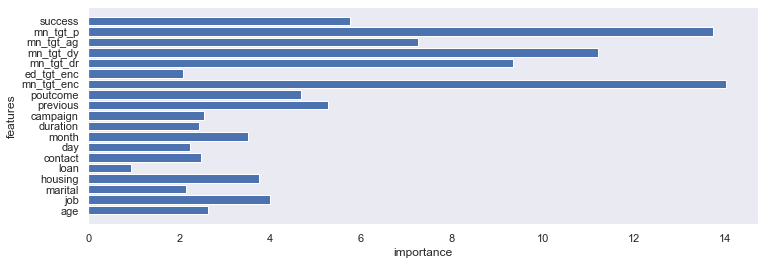

In [13]:
feature_importance = cat1.get_feature_importance()
plt.figure(figsize=(12, 4))
plt.barh(range(len(feature_importance)),
        feature_importance,
        tick_label=X.columns)

plt.xlabel('importance')
plt.ylabel('features')
plt.grid()
plt.show()

In [32]:

cat1.fit(X,y)
cat2.fit(X,y)
cat3.fit(X,y)

y_pred = cat1.predict(test_X)*0.30+cat2.predict(test_X)*0.4+cat3.predict(test_X)*0.3

# xgb1.fit(X,y)
# xgb2.fit(X,y)
# y_pred = xgb1.predict(test_X)*0.1+xgb2.predict(test_X)*0.9



0:	total: 9.65ms	remaining: 1.92s
1:	total: 16.8ms	remaining: 1.67s
2:	total: 26.2ms	remaining: 1.72s
3:	total: 35.7ms	remaining: 1.75s
4:	total: 43.7ms	remaining: 1.7s
5:	total: 50.8ms	remaining: 1.64s
6:	total: 58.4ms	remaining: 1.61s
7:	total: 63.5ms	remaining: 1.52s
8:	total: 66.4ms	remaining: 1.41s
9:	total: 69.8ms	remaining: 1.33s
10:	total: 72.2ms	remaining: 1.24s
11:	total: 74.5ms	remaining: 1.17s
12:	total: 77.1ms	remaining: 1.11s
13:	total: 80.1ms	remaining: 1.06s
14:	total: 82.3ms	remaining: 1.01s
15:	total: 84.3ms	remaining: 970ms
16:	total: 86.5ms	remaining: 932ms
17:	total: 89.1ms	remaining: 901ms
18:	total: 91.5ms	remaining: 872ms
19:	total: 94.1ms	remaining: 847ms
20:	total: 96.8ms	remaining: 825ms
21:	total: 99.4ms	remaining: 804ms
22:	total: 102ms	remaining: 782ms
23:	total: 104ms	remaining: 760ms
24:	total: 106ms	remaining: 740ms
25:	total: 110ms	remaining: 736ms
26:	total: 112ms	remaining: 720ms
27:	total: 115ms	remaining: 705ms
28:	total: 117ms	remaining: 689ms
29:

In [33]:
sub = pd.read_csv("submit_sample.csv",header=None)


In [34]:
sub[0] = test["id"]
sub[1] = y_pred
sub[1] = sub[1].apply(lambda x:0.000001 if x<0 else x)
# sub[1] = sub[1].apply(lambda x:0.999999 if x>=0.9 else x)
# sub[1] = sub[1].apply(lambda x:0.000001 if x<0.05 else x)
sub.to_csv("submission_20200808.csv",index=False,header=None)
sub

,0,1
0,0,0.728065
1,1,0.097630
2,2,0.029679
3,3,0.000001
4,4,0.050038
...,...,...
18045,18045,0.000001
18046,18046,0.015004
18047,18047,0.049657
18048,18048,0.000001


In [29]:
test_X = test_X.reset_index()
sub = sub[:1000]
nX = pd.concat([test_X,sub],axis=1).reset_index()
del nX[0]

print(nX)
# del nX["level_0"]
del nX["index"]
nX["y"] = nX[1]
del nX[1]
new_y = nX["y"]
del nX["y"]

ValueError: cannot insert level_0, already exists

In [25]:
new_y = new_y.apply(lambda x:1 if x>=0.5 else 0)

In [19]:
params_cat4 = {
    'depth' : 3,                  # 木の深さ
    'learning_rate' : 0.0001,       # 学習率
    'early_stopping_rounds' : 10,
    'iterations' : 200, 
    "eval_metric":"AUC", 
    'random_seed' :111
}
cat4 = CatBoostRegressor(**params_cat4)
kfold_auc(cat4,nX,new_y,4)

0:	total: 4.4ms	remaining: 876ms
1:	total: 11ms	remaining: 1.09s
2:	total: 13.7ms	remaining: 902ms
3:	total: 15.3ms	remaining: 749ms
4:	total: 16.6ms	remaining: 648ms
5:	total: 18.1ms	remaining: 587ms
6:	total: 19.8ms	remaining: 545ms
7:	total: 22.9ms	remaining: 549ms
8:	total: 25.9ms	remaining: 549ms
9:	total: 27.6ms	remaining: 525ms
10:	total: 29.2ms	remaining: 502ms
11:	total: 30.7ms	remaining: 481ms
12:	total: 32.1ms	remaining: 461ms
13:	total: 33.5ms	remaining: 445ms
14:	total: 35.9ms	remaining: 442ms
15:	total: 37.4ms	remaining: 430ms
16:	total: 38.7ms	remaining: 417ms
17:	total: 41.9ms	remaining: 424ms
18:	total: 43.4ms	remaining: 414ms
19:	total: 44.8ms	remaining: 403ms
20:	total: 46.1ms	remaining: 393ms
21:	total: 47.5ms	remaining: 384ms
22:	total: 49.5ms	remaining: 381ms
23:	total: 51ms	remaining: 374ms
24:	total: 53ms	remaining: 371ms
25:	total: 56.3ms	remaining: 377ms
26:	total: 57.8ms	remaining: 370ms
27:	total: 59.3ms	remaining: 364ms
28:	total: 60.9ms	remaining: 359ms
29

[0.9998414811996703,
 0.9870452528837622,
 0.9850827042628774,
 0.9887632143121166]

In [20]:
cat4.fit(nX,new_y)

y_pred = cat4.predict(test_X)

0:	total: 5.76ms	remaining: 1.15s
1:	total: 9.83ms	remaining: 974ms
2:	total: 14.9ms	remaining: 977ms
3:	total: 19.3ms	remaining: 948ms
4:	total: 24.4ms	remaining: 952ms
5:	total: 28.9ms	remaining: 933ms
6:	total: 33.3ms	remaining: 918ms
7:	total: 38.4ms	remaining: 921ms
8:	total: 41.3ms	remaining: 877ms
9:	total: 42.8ms	remaining: 812ms
10:	total: 44.5ms	remaining: 764ms
11:	total: 46.4ms	remaining: 727ms
12:	total: 48ms	remaining: 690ms
13:	total: 49.5ms	remaining: 658ms
14:	total: 50.9ms	remaining: 628ms
15:	total: 54ms	remaining: 621ms
16:	total: 58.9ms	remaining: 634ms
17:	total: 63.2ms	remaining: 640ms
18:	total: 67.3ms	remaining: 641ms
19:	total: 71.4ms	remaining: 643ms
20:	total: 75.9ms	remaining: 647ms
21:	total: 80.5ms	remaining: 651ms
22:	total: 83ms	remaining: 639ms
23:	total: 87.8ms	remaining: 644ms
24:	total: 92.3ms	remaining: 646ms
25:	total: 94.8ms	remaining: 634ms
26:	total: 96.4ms	remaining: 618ms
27:	total: 97.9ms	remaining: 602ms
28:	total: 102ms	remaining: 603ms
29

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:236: Feature index from pool must be level_0.

In [ ]:
sub = pd.read_csv("submit_sample.csv",header=None)
sub[0] = test["id"]
sub[1] = y_pred
sub[1] = sub[1].apply(lambda x:0.00001 if x<0 else x)
# sub[1] = sub[1].apply(lambda x:0.999999 if x>=0.9 else x)
# sub[1] = sub[1].apply(lambda x:0.000001 if x<0.05 else x)
sub.to_csv("submission_20200804.csv",index=False,header=None)

In [ ]:
sub